In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
from dpeva.uncertain.rnd import RandomNetworkDistillation

Initializing DP-EVA version 0.1.0


## Load descriptor example, 

descriptor shape : (nframe, ndim)

In [3]:
all_desc_stru = np.load('../data/desc.npy')
all_desc_stru.shape

(20873, 136)

## Random Network Distillation

The Random Network Distillation (RND) is a method to learn the representation of the environment and calculate the intrinsic reward of the target data. The idea is to train a neural network to predict the output of a fixed randomly initialized neural network. The fixed network is used to generate the target, and the trainable network is used to predict the target. The intrinsic reward is calculated by the difference between the target and the prediction which is used to train the agent to explore the environment. 

Here in MLIP active learning ,the 'agnet' is our MLIP and the environment is the atomistic space.

In [4]:
# randomly choose 80% of the data as training data
np.random.seed(19090)
train_index = np.random.choice(range(len(all_desc_stru)), int(0.8*len(all_desc_stru)), replace=False)
desc = all_desc_stru[train_index]
desc.shape

(16698, 136)

In [ ]:
# parameters, can be tuned
input_dim = desc.shape[-1]  # input dimension
output_dim = 240  # output dimension
hidden_dim = 240  # hidden dimension
num_residual_blocks = 1  # number of residual blocks
device = "cpu"  # device

# initialization
rnd = RandomNetworkDistillation(
            input_dim=input_dim, 
            output_dim=input_dim, 
            hidden_dim=hidden_dim, 
            num_residual_blocks=num_residual_blocks, 
            distance_metric="cossim", 
            device=device)

# fit the predictor network
rnd.train(desc, 
          num_batches=4500,
          batch_size=2048,
          initial_lr=1e-3,
          gamma=0.98,
          decay_steps=20,
          disp_freq=200,
          save_freq=1000)

2025-01-12 11:21:40,113 - INFO - Target network saved to ./models/target_network.pth
2025-01-12 11:21:40,116 - INFO - Target network saved to ./models/target_network.pth
2025-01-12 11:21:40,117 - INFO - Training started.
2025-01-12 11:21:40,120 - INFO - Predictor network saved to ./models/predictor_network.pth
2025-01-12 11:21:40,210 - INFO - Initial batch loss: 0.968220
2025-01-12 11:21:40,229 - INFO - Batch 0 trained, Time: 0.02s, Avg Loss: 0.656603
2025-01-12 11:21:43,497 - INFO - Batch 200/4000 trained, Time: 3.29s, Avg Loss: 0.017859
2025-01-12 11:21:46,766 - INFO - Batch 400/4000 trained, Time: 3.27s, Avg Loss: 0.001515
2025-01-12 11:21:50,046 - INFO - Batch 600/4000 trained, Time: 3.28s, Avg Loss: 0.001025
2025-01-12 11:21:53,292 - INFO - Batch 800/4000 trained, Time: 3.24s, Avg Loss: 0.000823


After training for predictor network, we can use the distance between target network and predictor network as the intrinsic reward for data to be sampled

In [16]:
%%time
intrinsic_rewards = []
batch_size = 4096 

# transform intrinsic_rewards to numpy array
intrinsic_rewards = rnd.eval_intrinsic_rewards(all_desc_stru, batch_size=batch_size)

2025-01-12 11:20:24,653 - INFO - Calculating intrinsic rewards for size 20873 with batch size 4096
2025-01-12 11:20:24,655 - INFO - Calculating intrinsic rewards for batch 1/6
2025-01-12 11:20:26,060 - INFO - Calculating intrinsic rewards for batch 2/6
2025-01-12 11:20:27,492 - INFO - Batch 2/6 completed, Time: 2.84s, 
2025-01-12 11:20:27,492 - INFO - Calculating intrinsic rewards for batch 3/6
2025-01-12 11:20:28,889 - INFO - Calculating intrinsic rewards for batch 4/6
2025-01-12 11:20:30,299 - INFO - Batch 4/6 completed, Time: 2.81s, 
2025-01-12 11:20:30,299 - INFO - Calculating intrinsic rewards for batch 5/6
2025-01-12 11:20:31,740 - INFO - Calculating intrinsic rewards for batch 6/6
2025-01-12 11:20:31,876 - INFO - Batch 6/6 completed, Time: 1.58s, 
2025-01-12 11:20:31,877 - INFO - Intrinsic rewards calculation done


CPU times: user 7.22 s, sys: 8.46 ms, total: 7.23 s
Wall time: 7.22 s


In [17]:
# top 200 unique points
top_50_indices = np.argsort(intrinsic_rewards)[-50:]  
top_50_points = all_desc_stru[top_50_indices]  

print("Indices of Top 200 points with highest intrinsic rewards:", top_50_indices)

Indices of Top 200 points with highest intrinsic rewards: [ 7509  7512  7516  7510 15899  7515 18328  7505 15948  7502  7504 15966
  7508  7518 15944 15906 15939 16004 18101 15945 15963 15901 15971 15936
 15904 15981 18349 18301 18306 15957 15910 18294 12453  5738  5769  6166
  5759 13020  5739  5722  6173  7521 15273  4223  6749  5758  7522  5772
  6159  7519]


## Visualizing the uncertainty (reward) results

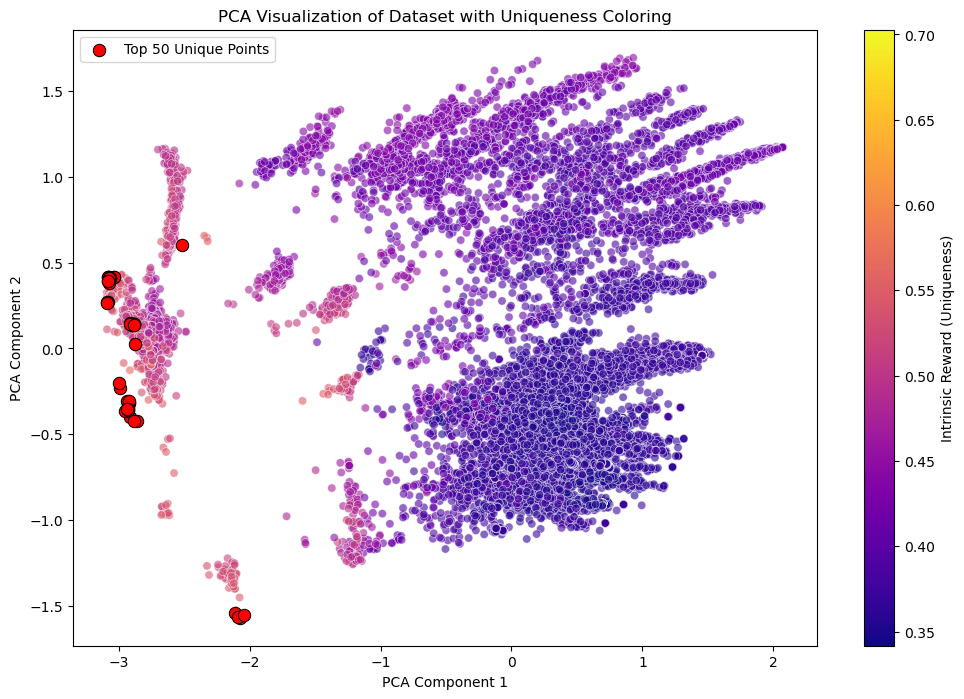

In [18]:
# PCA reduction
pca = PCA(n_components=2) 
pca_result = pca.fit_transform(all_desc_stru) 
top_50_pca_result = pca.transform(top_50_points) # PCA reduction for top 200 unique points in the same space

plt.figure(figsize=(12, 8))

ax = sns.scatterplot(
    x=pca_result[:, 0], y=pca_result[:, 1],
    hue=intrinsic_rewards, palette="plasma", alpha=0.6, legend=False
)

sns.scatterplot(
    x=top_50_pca_result[:, 0], y=top_50_pca_result[:, 1],
    color="red", label="Top 50 Unique Points", s=80, edgecolor="black"
)

norm = plt.Normalize(intrinsic_rewards.min(), intrinsic_rewards.max())
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Intrinsic Reward (Uniqueness)")  # 指定 ax 参数

# 添加标题和标签
plt.title("PCA Visualization of Dataset with Uniqueness Coloring")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

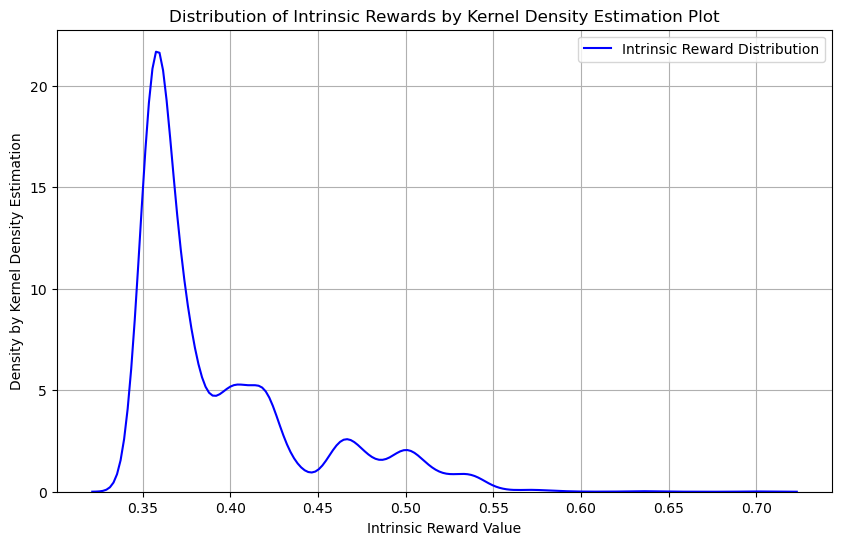

In [19]:
plt.figure(figsize=(10, 6))
sns.kdeplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution")  # 
plt.title("Distribution of Intrinsic Rewards by Kernel Density Estimation Plot")
plt.xlabel("Intrinsic Reward Value")
plt.ylabel("Density by Kernel Density Estimation")
plt.legend()
plt.grid(True)
plt.show()

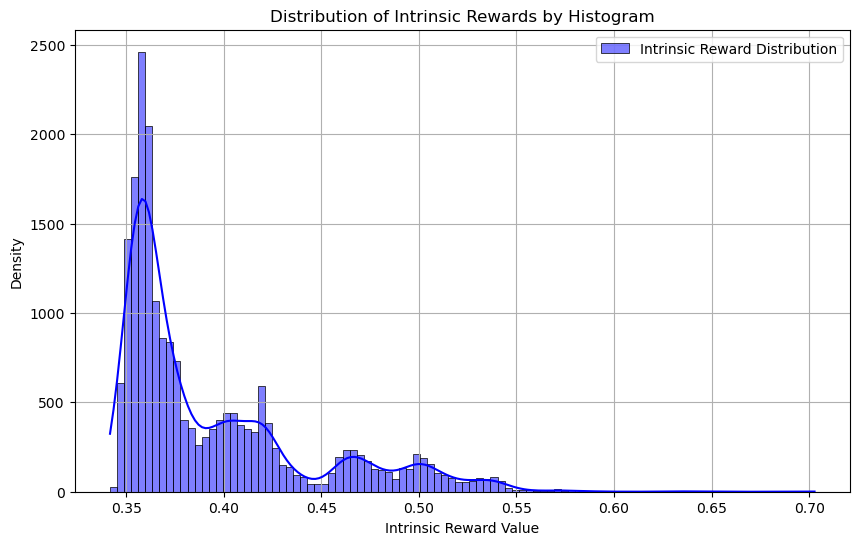

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution", bins=100, kde=True)
plt.title("Distribution of Intrinsic Rewards by Histogram")
plt.xlabel("Intrinsic Reward Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()